# 2D Griffith Crack inverse problem (2DP0)

When the traction boundary conditions are specified as follows,
$$
t(x) =
    \begin{cases}
        \sigma_A & \text{if } x \leq |a|\\
        0 & \text{if } x > |a|
    \end{cases}
$$

The displacement solution for the Griffith crack is given as seen in Weertman (1996) as,
$$
D(x) = {2 (1-\nu) \sigma_A \over G} \sqrt{a^2 - x^2}
$$

In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from matplotlib import ticker, cm, colors

from scipy.sparse.linalg import gmres

np.set_printoptions(precision=5, suppress=True)

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [3.5, 3.5]
plt.rcParams['font.size'] = 15
plt.rcParams['text.usetex']=True
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.1
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["text.latex.preamble"] =r'\usepackage{amsmath}'+ r'\usepackage{amssymb}' + r'\usepackage{accents}'+ r'\usepackage{bm}'+ r'\boldmath'+ r'\renewcommand{\v}[1]{\boldsymbol{{#1}}}'+ r'\DeclareRobustCommand{\sot}[1]{\boldsymbol{{#1}}}'

norm1 = lambda a : np.linalg.norm(a, axis=1)
norm = lambda a : np.linalg.norm(a)

home = os.environ['HOME'] 
# sys.path.append(home + "/geolab/dev_bigwham/build/interfaces/python")
# from bigwham4py import Hmatrix  # linear operator file

sys.path.append(home + "/Desktop/GEL/BigWham/build/interfaces/python")
from hmatrix import Hmatrix  # linear operator file
os.environ["OMP_NUM_THREADS"] = "4"

In [2]:
pressure = 1.0

G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)
sigma_A = 1.0

pre_fac = 2*((1 - nu)/G)

# Mesh
a = 1.0
nelts = 100
coor1D = np.linspace(-a, a, nelts + 1)
coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)

# H-matrix parameter
max_leaf_size=100
eta=3.
eps_aca=1.e-4

# Hmatrix
kernel = "2DP0"
elas_prop = np.array([E, nu])
hmat = Hmatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)

col_pts = hmat.getMeshCollocationPoints()

 Now setting things for kernel ... 2DP0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  2.87e-07
Binary cluster tree depth = 0
Number of blocks = 1
Number of full blocks = 1
Number of low rank blocks = 0
Pattern Created 
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 0.00544394
Compression ratio - 1
Hmat object - built 
HMAT --> built 
HMAT set, CR = 1, eps_aca = 0.0001, eta = 3
BigWhamIO ENDED


In [3]:
trac = np.zeros(col_pts.shape)
trac[:, 1] = pressure

print("Number of OMP threads {}".format(os.environ["OMP_NUM_THREADS"]))

u, info = gmres(hmat, hmat.convert_to_local(trac.flatten()))
dd_calc = hmat.convert_to_global(u)

Number of OMP threads 4


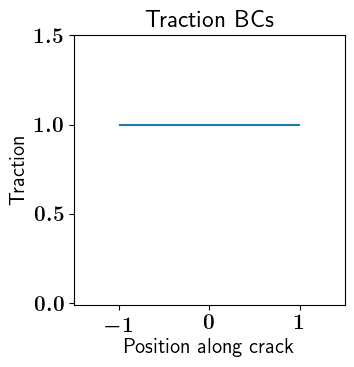

In [4]:
plt.plot(col_pts[:, 0], trac[:, 1])
plt.title("Traction BCs")
plt.xlabel("Position along crack")
plt.ylabel("Traction")
plt.xlim([-1.5, 1.5])
plt.ylim([-.01, 1.5])
plt.show()

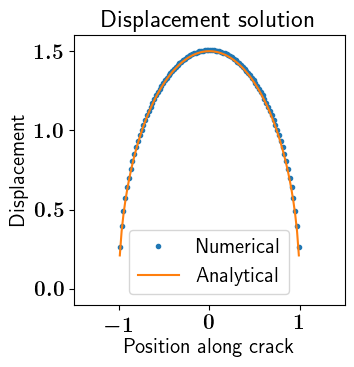

In [6]:
#analytical solution for displacement for the crack
dd_ref = np.zeros(col_pts.shape)
dd_ref[:, 1] = pre_fac * np.sqrt(a**2 - col_pts[:, 0]**2)

plt.figure()
#plt.plot(np.linalg.norm(col_pts, axis=1), dd_calc.reshape(-1, 2), ".k")
plt.title("Displacement solution")
plt.xlabel("Position along crack")
plt.ylabel("Displacement")
plt.xlim([-1.5, 1.5])
plt.ylim([-0.1, 1.6])
plt.plot(col_pts[:, 0], dd_calc.reshape(-1, 2)[:, 1], ".")
plt.plot(col_pts[:, 0], dd_ref.reshape(-1, 2)[:, 1])
plt.legend(["Numerical", "Analytical"])

In [7]:
rel_err = np.linalg.norm(dd_ref.flatten() - dd_calc) / dd_ref.shape[0]
print("L2 Rel error {}".format(rel_err))

L2 Rel error 0.001375101583671952


In [9]:
pressure = 1.0

G = 1.0
nu = 0.25
E = (2 * G) * (1 + nu)
sigma_A = 1.0

pre_fac = 2*((1 + nu)/G)

nelts_array = [10**i for i in range(1, 5)]
rel_error_array = []

# H-matrix parameter
max_leaf_size = 100
eta = 3.
eps_aca = 1.e-4

for nelts in nelts_array:
    # Mesh
    coor1D = np.linspace(-a, a, nelts + 1)
    coor = np.transpose(np.array([coor1D, coor1D * 0.0]))
    conn = np.fromfunction(lambda i, j: i + j, (nelts, 2), dtype=np.int_)

    # Hmatrix
    kernel = "2DP0"
    elas_prop = np.array([E, nu])
    hmat = Hmatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)

    col_pts = hmat.getMeshCollocationPoints()

    trac = np.zeros(col_pts.shape)
    trac[:, 1] = pressure

    print("Number of OMP threads {}".format(os.environ["OMP_NUM_THREADS"]))

    u, info = gmres(hmat, hmat.convert_to_local(trac.flatten()))
    dd_calc = hmat.convert_to_global(u)

    dd = np.zeros(col_pts.shape)
    dd[:, 1] = pre_fac * np.sqrt(a**2 - col_pts[:, 0]**2)

    rel_err = np.linalg.norm(dd.flatten() - dd_calc) / dd.shape[0]
    print("L2 Rel error {}".format(rel_err))
    rel_error_array.append(rel_err)

Number of OMP threads 4
L2 Rel error 0.2298936674216579
 Now setting things for kernel ... 2DP0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  2.79e-07
Binary cluster tree depth = 0
Number of blocks = 1
Number of full blocks = 1
Number of low rank blocks = 0
Pattern Created 
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low rank blocks 0
dof_dimension: 2
Creation of hmat done in 9.204e-05
Compression ratio - 1
Hmat object - built 
HMAT --> built 
HMAT set, CR = 1, eps_aca = 0.0001, eta = 3
BigWhamIO ENDED
Number of OMP threads 4
 Now setting things for kernel ... 2DP0 with properties size 2
Cluster tree creation time :  0
Time for binary cluster tree construction  1.81e-07
Binary cluster tree depth = 0
Number of blocks = 1
Number of full blocks = 1
Number of low rank blocks = 0
Pattern Created 
 Loop on full blocks construction  
 N full blocks 1 
Loop on low rank blocks construction
N low

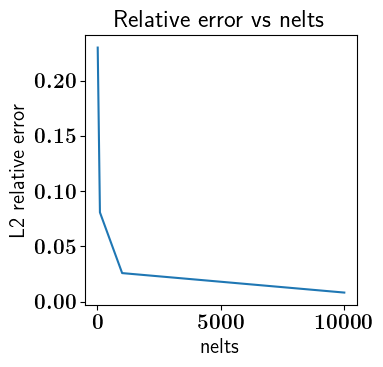

In [10]:
plt.figure()
plt.plot(nelts_array, rel_error_array)
plt.title("Relative error vs nelts")
plt.xlabel("nelts")
plt.ylabel("L2 relative error")
#saves fig - remember to remove
#plt.savefig('rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

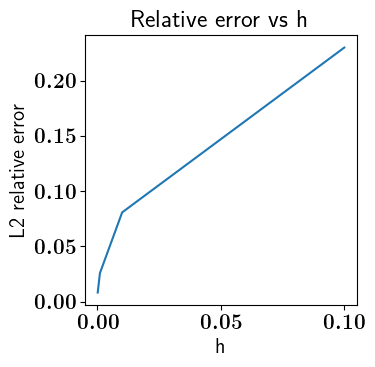

In [11]:
h_array = [1/nelts for nelts in nelts_array]

plt.figure()
plt.plot(h_array, rel_error_array)
plt.title("Relative error vs h")
plt.xlabel("h")
plt.ylabel("L2 relative error")
#saves fig - remember to remove
#plt.savefig('rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

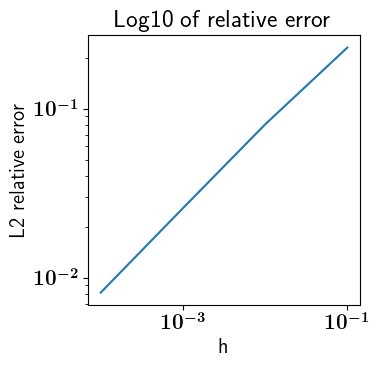

In [12]:
plt.figure()
plt.plot(h_array, rel_error_array)
plt.title("Log10 of relative error")
plt.xlabel("h")
plt.ylabel("L2 relative error")
plt.yscale('log')
plt.xscale('log')
#saves fig - remember to remove
#plt.savefig('log_rel_err_h.png', dpi=100, bbox_inches='tight')
plt.show()

In [ ]:
print(h_array)
print(rel_error_array)

[0.1, 0.01, 0.001, 0.0001, 1e-05]
[2.298936674216587, 0.807347540830766, 0.2579118570706137, 0.08164175231521707, 0.025820064551278797]


In [13]:
log_h = np.log(np.asarray(nelts_array)[2:])
log_rel_array = np.log(np.asarray(rel_error_array)[2:])

m, c = np.polyfit(log_h, log_rel_array, 1)

print(m)
print(c)

-0.49955899147512933
-0.2068912233005046


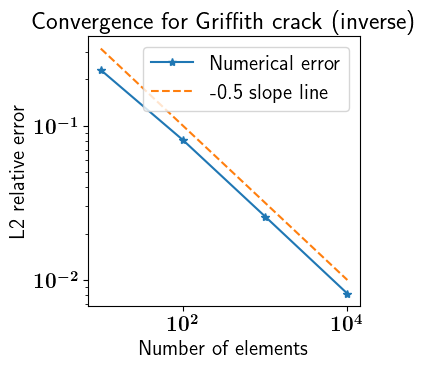

In [16]:
plt.figure()
plt.plot(nelts_array, rel_error_array, "*-")
plt.plot(nelts_array, 1*np.array(nelts_array) ** (-0.5) , "--")
plt.title("Convergence for Griffith crack (inverse)")
plt.legend(["Numerical error", "-0.5 slope line"])
plt.xlabel("Number of elements")
plt.ylabel("L2 relative error")
plt.yscale('log',base=10)
plt.xscale('log',base=10)
#saves fig - remember to remove
# plt.savefig('log2_rel_err_h.png', dpi=100, bbox_inches='tight')
# plt.show()